# TODO
- [] much tidy 
- [] get data from azure
- [] visualize inference on a map
- [] wrap processpool executor

In [1]:
import concurrent.futures
import image_slicer
from pathlib import Path
import glob
import image_slicer
from PIL import Image
from tqdm import tqdm
import concurrent.futures
import glob
from functools import partial
import shutil
import os

from fastai.vision import *
Image.MAX_IMAGE_PIXELS = None
from pathlib import Path

%matplotlib inline

In [2]:
# working
%time
def slice_map_pool(image):
    fname = Path(image).stem
    tiles = image_slicer.slice(image, 4, save=False)
    image_slicer.save_tiles(tiles, prefix=fname, directory='test', format='jpeg')

ext='jpg'
in_directory = 'data/Sample_OS_town_plans_London_1890s_compressed'
with concurrent.futures.ProcessPoolExecutor() as executor:
    image_files = Path(in_directory).glob('**/*.' + ext)
    result = executor.map(slice_map_pool, image_files)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


KeyboardInterrupt: 

In [ ]:
def slice_map(image,ext='tiff', num_tiles=4, out_dir=False, out_format='jpeg'):
    fname = Path(image).stem
    tiles = image_slicer.slice(image, int(num_tiles), save=False)
    image_slicer.save_tiles(tiles, prefix=fname, directory=out_dir, format=out_format)

In [ ]:
def slice_pool(in_directory, ext='jpg'):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        image_files = Path(in_directory).glob('**/*.' + ext)
        result = executor.map(_slice, image_files)

In [ ]:
slice_pool(in_directory='data/Sample_OS_town_plans_London_1890s_compressed', ext='jpg')

In [ ]:
##### Above works 



In [ ]:
def map2tiles(in_directory, in_ext='tiff', tiles=4, out_dir=None, out_format='jpeg'):
    if out_dir:
            Path(out_dir).mkdir(exist_ok=True)
    else:
        out_dir = Path('.')
    _slice_map = partial(slice_map, ext=in_ext, num_tiles=tiles, out_dir=out_dir, out_format=out_format)
    with concurrent.futures.ProcessPoolExecutor() as executor:
        image_files = Path(in_directory).glob('**/*.' + ext)
        result = executor.map(_slice_map, image_files)

In [ ]:
%%time
map2tiles(in_directory='data/Sample_OS_town_plans_London_1890s_compressed', in_ext='jpg', out_dir='slices_64', tiles=64)

## Annotating in the notebook 

In [3]:
map_tiles_sample = glob.glob('slices_64_sample/*.jpg')

In [4]:
from pigeon import annotate
from IPython.display import display, Image

annotations = annotate(
  map_tiles_sample,
  options=['building', 'no_building'],
  display_fn=lambda filename: display(Image(filename))
)

HTML(value='0 examples annotated, 201 examples left')

Output()

Annotation done.


In [5]:
annotations

[('slices_64_sample/101200791.27_03_04.jpg', 'building'),
 ('slices_64_sample/101200785.27_03_02.jpg', 'no_building'),
 ('slices_64_sample/101200749.27_04_06.jpg', 'no_building'),
 ('slices_64_sample/101200797.27_01_06.jpg', 'building'),
 ('slices_64_sample/101200764.27_05_02.jpg', 'no_building'),
 ('slices_64_sample/101200770.27_05_04.jpg', 'building'),
 ('slices_64_sample/101200776.27_07_06.jpg', 'building'),
 ('slices_64_sample/101200755.27_07_05.jpg', 'no_building'),
 ('slices_64_sample/101200782.27_03_02.jpg', 'building'),
 ('slices_64_sample/101200788.27_05_04.jpg', 'no_building'),
 ('slices_64_sample/101200794.27_06_07.jpg', 'building'),
 ('slices_64_sample/101200779.27_04_03.jpg', 'building'),
 ('slices_64_sample/101200758.27_01_03.jpg', 'no_building'),
 ('slices_64_sample/101200761.27_07_08.jpg', 'no_building'),
 ('slices_64_sample/101200740.27_02_08.jpg', 'no_building'),
 ('slices_64_sample/101200740.27_05_01.jpg', 'no_building'),
 ('slices_64_sample/101200746.27_07_03.jpg', 

In [6]:
import pickle 

In [7]:
with open('annotations.pkl', 'wb') as annotations_dump:
    pickle.dump(annotations, annotations_dump)

In [8]:
with open('annotations.pkl','rb') as annotations_file:
    annotations = pickle.load(annotations_file)

In [ ]:
os.mkdir('slices_64_sample')
for f, _ in annotations:
    shutil.copy(f,'slices_64_sample')

In [9]:
labels_dict = dict(annotations)

In [11]:
labels_dict['slices_64_sample/101200785.27_03_02.jpg']

'no_building'

In [12]:
func = lambda x: labels_dict[str(x)]

In [ ]:
annotations

In [13]:
building_data = (ImageList.from_folder('slices_64_sample') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.2)
        .label_from_func(func)
        .transform(size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())        

In [14]:
building_data

ImageDataBunch;

Train: LabelList (160 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
no_building,no_building,building,building,building
Path: slices_64_sample;

Valid: LabelList (40 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
building,no_building,building,no_building,no_building
Path: slices_64_sample;

Test: None

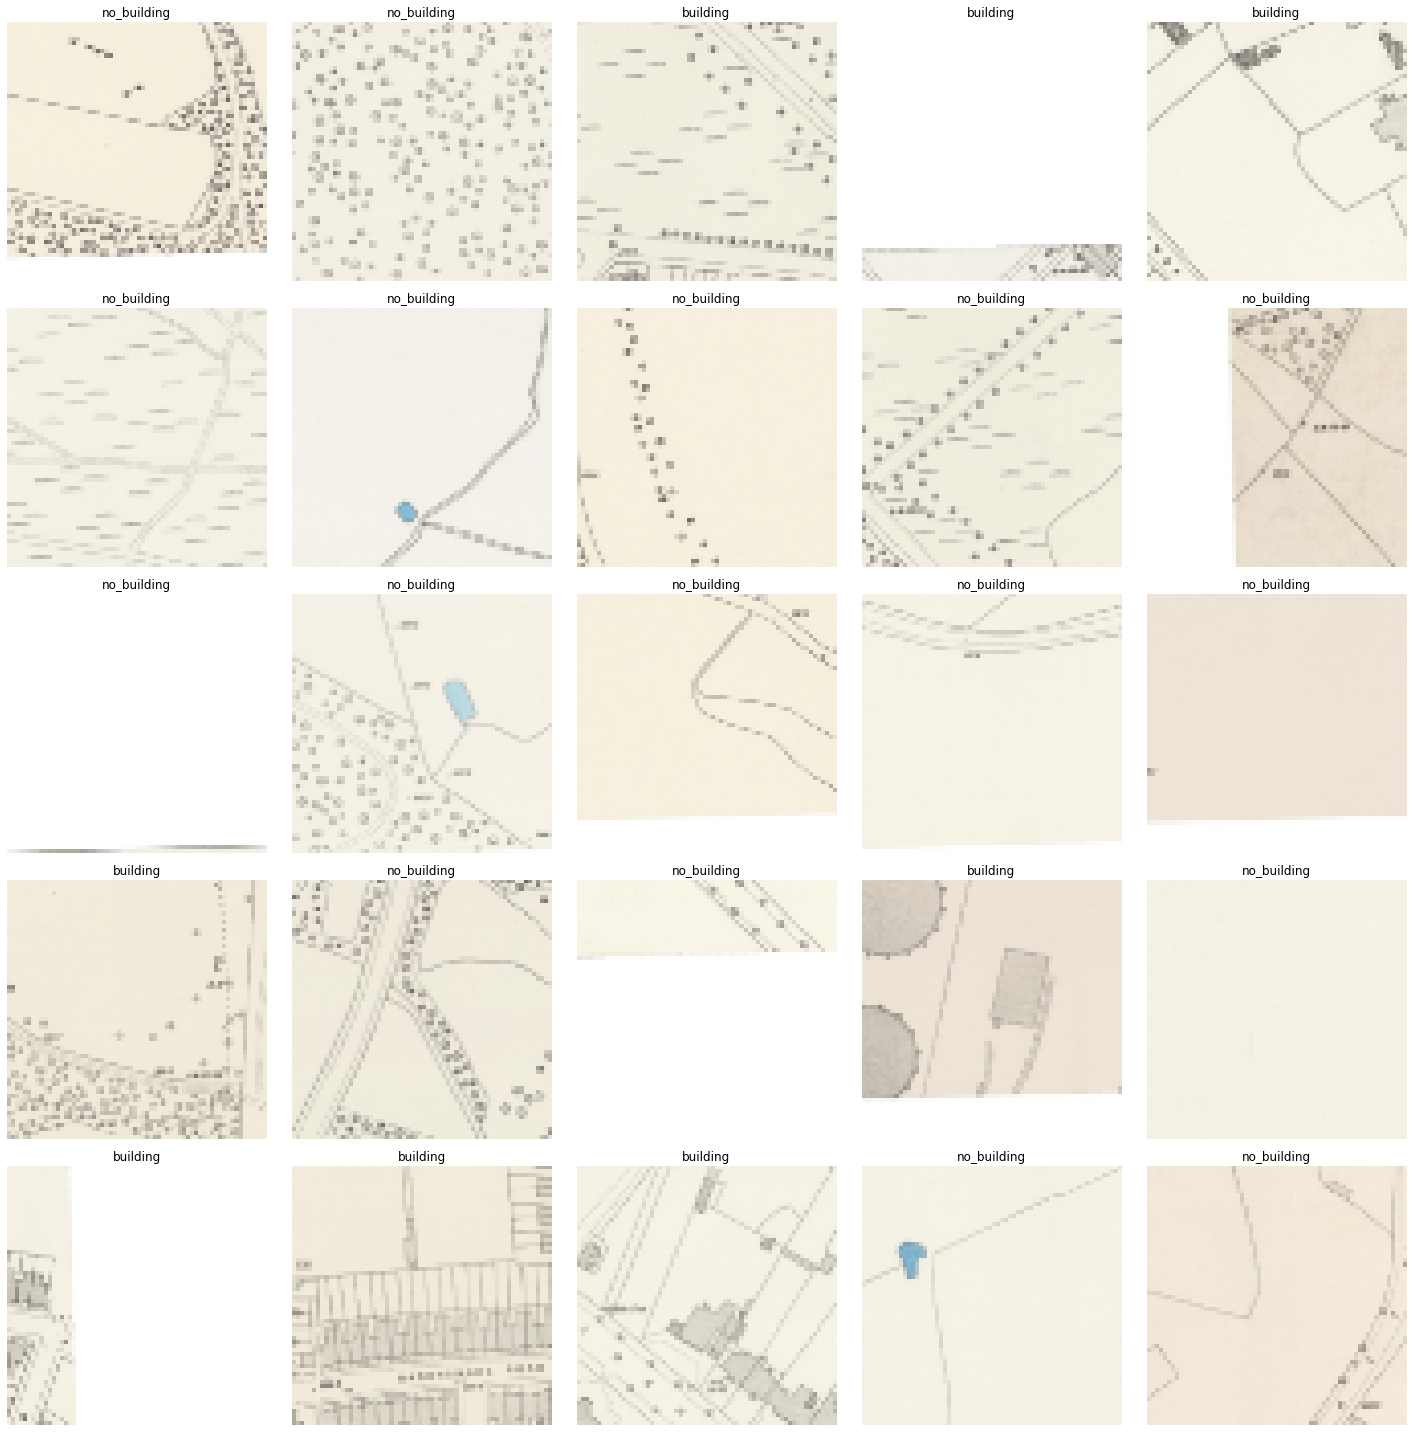

In [15]:
building_data.show_batch()

In [16]:
learn = cnn_learner(building_data, models.resnet34, metrics=accuracy)

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


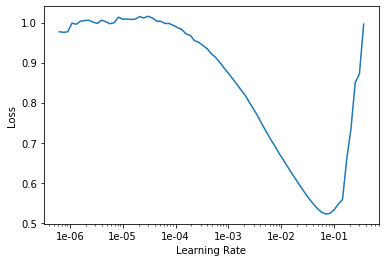

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.901656,0.925155,0.375000,00:04
1,0.692031,0.944735,0.350000,00:04
2,0.520964,0.901543,0.525000,00:04
3,0.434635,0.410091,0.800000,00:04
4,0.354152,0.493749,0.800000,00:04


In [ ]:
learn.recorder.plot_losses()

In [20]:
learn.save('stage-1')
learn = learn.load('stage-1')

In [21]:
building_data_2 = (ImageList.from_folder('slices_64_sample') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.2)
        .label_from_func(func)
        .transform(size=128)       #Data augmentation? -> use tfms with a size of 64
        .databunch())

In [22]:
learn.data = building_data_2

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


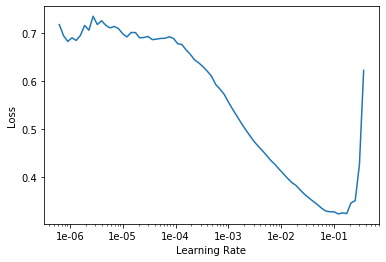

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(5, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.686463,0.431461,0.875000,00:07
1,0.567058,0.807332,0.750000,00:07
2,0.401568,0.985614,0.725000,00:07
3,0.310234,1.141439,0.725000,00:07
4,0.267957,1.240231,0.725000,00:07


In [27]:
building_data_3 = (ImageList.from_folder('slices_64_sample') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.2)
        .label_from_func(func)
        .transform(size=256)       #Data augmentation? -> use tfms with a size of 64
        .databunch())     

In [28]:
learn.data = building_data_3

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(5, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.459570,0.107325,0.925000,00:21
1,0.338908,0.080005,0.950000,00:25
2,0.253701,0.166194,0.950000,00:23
3,0.198396,0.159558,0.950000,00:24
4,0.161315,0.171163,0.950000,00:24


In [34]:
#learn.save('stage-3')
learn = learn.load('stage-3')

In [35]:
building_data_4 = (ImageList.from_folder('slices_64_sample') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.3)
        .label_from_func(func)
        .transform(size=512)       #Data augmentation? -> use tfms with a size of 64
        .databunch())     

In [36]:
learn.data = building_data_4

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.00E-02


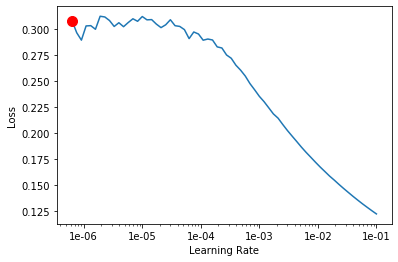

In [37]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [38]:
learn.fit_one_cycle(1, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.303181,0.337935,0.883333,01:32


In [39]:
learn.unfreeze
learn.fit_one_cycle(2, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.114710,0.248610,0.916667,01:39
1,0.070310,0.252652,0.900000,01:43


In [40]:
learn.save('final-building-detector')

In [44]:
learn = learn.load('final-building-detector')

In [45]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (140 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
building,no_building,no_building,building,building
Path: slices_64_sample;

Valid: LabelList (60 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
no_building,no_building,no_building,building,building
Path: slices_64_sample;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64,

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

In [ ]:
img

In [ ]:
def predict_tiles(image):
    tiles = image_slicer.slice(image, 64, save=False)
    for tile in tiles:
        img = open_image(tile.image)
        pred_class,pred_idx,outputs = learn.predict(img)
        print(pred_class,pred_idx)
#predict_tiles('117917133.27.tif')

In [ ]:
import numpy as np
image = '117917133.27.tif'
tiles = image_slicer.slice(image, 32, save=False)
for tile in tiles:
    #print(type(tile.image))
    x = np.array(tile.image)
  #  x = np.random.randn(3, 256, 256)
    img = Image(torch.from_numpy(x).float())
    learn.predict(img)


In [ ]:
new_map = '117917133.27.tif'

In [ ]:
def slice_map(image):
    fname = Path(image).stem
    tiles = image_slicer.slice(image, 32, save=False)
    image_slicer.save_tiles(tiles, prefix=fname, directory='test', format='jpeg')


In [ ]:
slice_map(new_map)

In [ ]:
test_tiles = glob.glob('test/*.jpg')

In [ ]:
for tile in test_tiles:
    img = open_image(tile)
    pred_class,pred_idx,outputs = learn.predict(img)
    print(tile)
    print(pred_class,pred_idx,outputs)
    print('------------------')

In [ ]:
# predicting on a tensor 

img = pil2tensor(img, np.float32)
img = Image(img)
pred = learn.predict(img)

In [ ]:
def predict_tiles(image):
    tiles = image_slicer.slice(image, 64, save=False)
    for tile in tiles:
        img = pil2tensor(tile.image, np.float32)
        img = Image(img)
        pred = learn.predict(img)
        print(pred)